# Import libraries and load dataset

In [37]:
# Use pandas to load data from a CSV file
import pandas as pd
# Use numpy for numerical operations
import numpy as np
# Use matplotlib for plotting
import matplotlib.pyplot as plt
# Use seaborn for enhanced plotting
import seaborn as sns
# Use ipaddress to convert IP to binary format
import ipaddress
# Use os for file path operations
import os

# Data Preprocessing
Create sampled dataset and train-test split datasets

In [38]:
# Specify path to directory of each malware class
malware_types = ['Adware','Benign','Ransomware','Scareware','SMSmalware']

# Each directory in malware_types contains nested directories of different families of malware of that type
# Each nested directory contains multiple CSV files of different samples of that family
# Load all families of data of each type of malware into a single dataframe
malware_data = {}
for malware_type in malware_types:
    malware_df = []
    for subdir in os.listdir(malware_type):
        subdir_path = os.path.join(malware_type, subdir)
        if os.path.isdir(subdir_path):
            for file in os.listdir(subdir_path):
                if file.endswith('.csv'):
                    file_path = os.path.join(subdir_path, file)
                    df = pd.read_csv(file_path)
                    # Drop the old 'Label' column if it exists
                    if ' Label' in df.columns:
                        df.drop(columns=[' Label'], inplace=True)
                    df['Label'] = malware_type
                    malware_df.append(df)
    combined_malware_df = pd.concat(malware_df, ignore_index=True)
    malware_data[malware_type] = combined_malware_df

In [39]:
# Combine all malware dataframes into a single dataframe
combined_malware_df = pd.concat(malware_data.values(), ignore_index=True)

# Go through each column and remove whitespace from the column names
combined_malware_df.columns = combined_malware_df.columns.str.strip()

# Drop 'Flow ID' column
combined_malware_df.drop(columns=['Flow ID'], inplace=True)

# Drop the 'Timestamp' column
combined_malware_df.drop(columns=['Timestamp'], inplace=True)

# Convert IP fields to integer format
def ip_to_int(ip):
    try:
        return int(ipaddress.ip_address(ip))
    except ValueError:
        return np.nan  # Handle invalid IP addresses

combined_malware_df['Source IP'] = combined_malware_df['Source IP'].apply(ip_to_int)
combined_malware_df['Destination IP'] = combined_malware_df['Destination IP'].apply(ip_to_int)

In [ ]:
# Print the first few rows of the combined dataframe to check the data
print(combined_malware_df.head())

In [ ]:
# Print non-floating columns to check for any non-numeric data
non_float_columns = combined_malware_df.select_dtypes(exclude=[np.float64]).columns
print("Non-float columns:", non_float_columns)

# Check unique non-float values in the non-float columns, excluding 'Timestamp' and 'Label'
for col in non_float_columns:
    if col in ['Timestamp', 'Label']:
        continue
    unique_values = combined_malware_df[col].unique()
    for value in unique_values:
        if not isinstance(value, (int, float)):
            print(f"Column: {col}, Value: {value}, Type: {type(value)}")

In [41]:
# For all string values in the non-float columns, excluding the 'Timestamp' and 'Label' columns, strip whitespace and try to typecast to float64
for col in non_float_columns:
    if col != 'Timestamp' and col != 'Label':
        combined_malware_df[col] = combined_malware_df[col].astype(str).str.strip()
        try:
            combined_malware_df[col] = combined_malware_df[col].astype(np.float64)
        except:
            # Replace the non-convertible values with 0
            combined_malware_df[col] = pd.to_numeric(combined_malware_df[col], errors='coerce').fillna(0)

# Print remaining unique non-float values in the non-float columns
for col in non_float_columns:
    if col in ['Timestamp', 'Label']:
        continue
    unique_values = combined_malware_df[col].unique()
    for value in unique_values:
        if not isinstance(value, (int, float)):
            print(f"Column: {col}, Value: {value}, Type: {type(value)}")

In [42]:
# Temporarily store the 'Label' column for later use
labels = combined_malware_df['Label'].copy()

In [ ]:
# Restore the 'Label' column to the combined dataframe (in case following block errors and does not restore it)
combined_malware_df['Label'] = labels

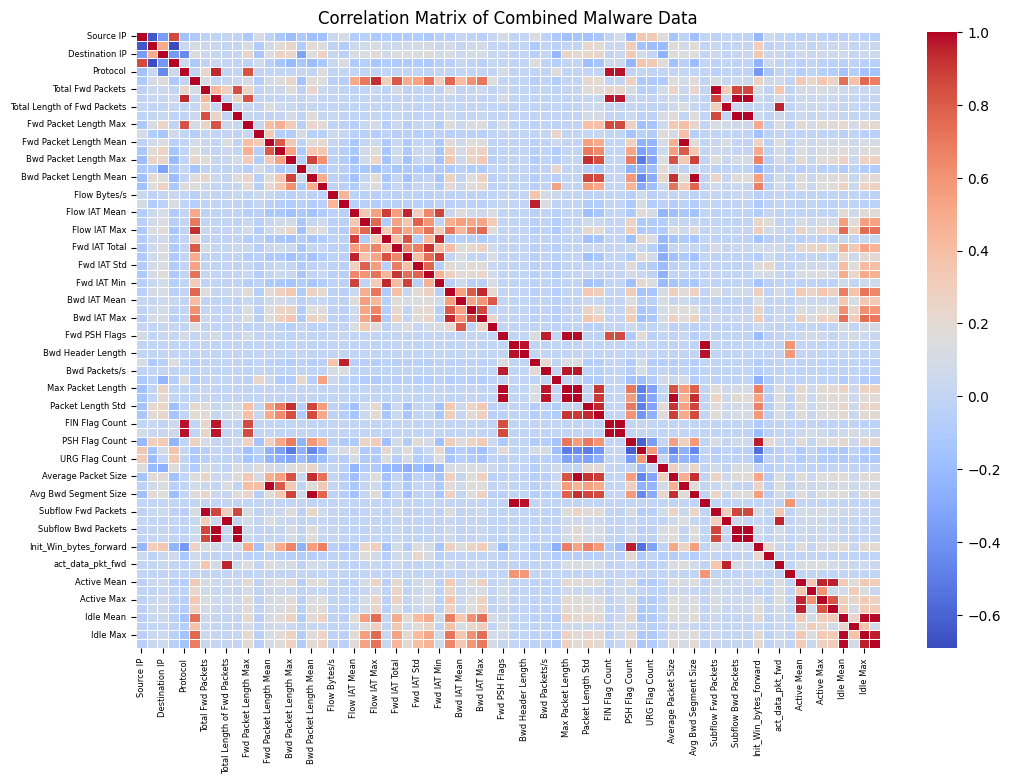

In [48]:
# Drop the 'Label' column for correlation analysis
combined_malware_df.drop(columns=['Label'], inplace=True)

# Show the correlation matrix of the combined malware dataframe
plt.figure(figsize=(12, 8))
sns.heatmap(combined_malware_df.corr(), annot=False, cmap='coolwarm', linewidths=0.5, fmt=".1f")
# Make the tick labels smaller
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.title('Correlation Matrix of Combined Malware Data')
plt.show()

# Restore the 'Label' column to the combined dataframe
combined_malware_df['Label'] = labels

In [47]:
# Print the column names of the combined dataframe
print("Column names in the combined dataframe:")
print(combined_malware_df.columns.tolist())

Column names in the combined dataframe:
['Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'Dow

In [46]:
# Select columns with high correlation or high negative correlation to reduce training time and complexity, or no correlation
drop_cols_no_corr = ['CWE Flag Count', 'ECE Flag Count', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 
                     'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']

drop_cols_nan_values = ['Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'RST Flag Count']

# Drop columns if they exist in the dataframe
for col in drop_cols_no_corr + drop_cols_nan_values:
    if col in combined_malware_df.columns:
        combined_malware_df.drop(columns=[col], inplace=True, errors='ignore')

In [ ]:
# Restore the 'Label' column to the combined dataframe (in case following block errors and it needs to be restored)
combined_malware_df['Label'] = labels

In [ ]:
# Drop columns with an absolute value correlation of 95% or higher with any other column

# Drop the 'Label' column for correlation analysis
combined_malware_df.drop(columns=['Label'], inplace=True)

# Compute the correlation matrix
corr_matrix = combined_malware_df.corr().abs()

# Select the upper triangle of the correlation matrix
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Find columns with correlation > max_correlation
max_correlation = 0.95
drop_cols = [column for column in upper.columns if any(upper[column] > max_correlation)]
cleaned_df = combined_malware_df.drop(columns=drop_cols, errors='ignore')

# Restore the 'Label' column to the cleaned dataframe
cleaned_df['Label'] = labels

In [ ]:
# Restore the 'Label' column to the cleaned dataframe (in case following block errors and it needs to be restored)
cleaned_df['Label'] = labels

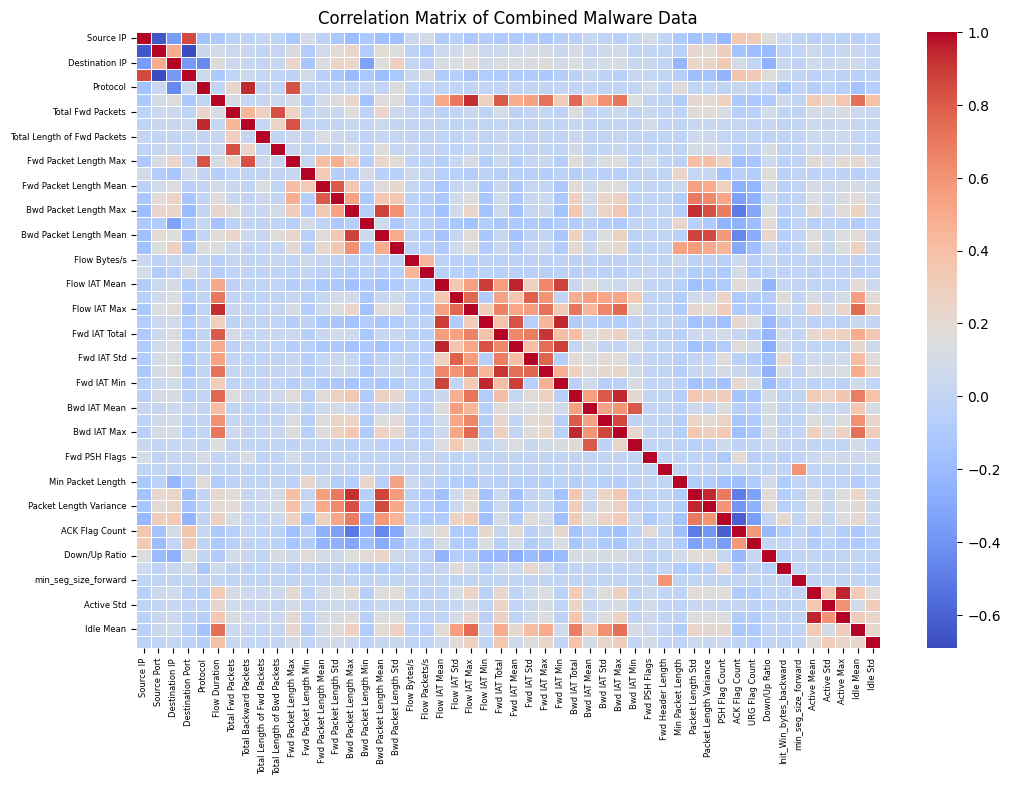

In [51]:
# Drop the 'Label' column for correlation analysis
cleaned_df.drop(columns=['Label'], inplace=True)

# Show the correlation matrix of the combined malware dataframe
plt.figure(figsize=(12, 8))
sns.heatmap(cleaned_df.corr(), annot=False, cmap='coolwarm', linewidths=0.5, fmt=".1f")
# Make the tick labels smaller
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.title('Correlation Matrix of Combined Malware Data')
plt.show()

# Restore the 'Label' column to the combined dataframe
cleaned_df['Label'] = labels

In [52]:
# Sample n rows from each malware type
num_samples = 50000
sampled_dfs = []
for malware_type in malware_types:
    sampled_df = cleaned_df[cleaned_df['Label'] == malware_type].sample(n=num_samples, random_state=42, replace=True)
    sampled_dfs.append(sampled_df)

# Concatenate the sampled dataframes into a single dataframe
sampled_df = pd.concat(sampled_dfs, ignore_index=True)

In [53]:
# Print the number of samples for each malware type
print("Number of samples for each malware type:")
for malware_type in malware_types:
    count = sampled_df[sampled_df['Label'] == malware_type].shape[0]
    print(f"{malware_type}: {count} samples")

Number of samples for each malware type:
Adware: 50000 samples
Benign: 50000 samples
Ransomware: 50000 samples
Scareware: 50000 samples
SMSmalware: 50000 samples


In [54]:
# Save the sampled dataframe to a CSV file
output_file = 'sampled_malware_data.csv'
sampled_df.to_csv(output_file, index=False)

In [55]:
# Load the sampled dataframe from the CSV file
loaded_df = pd.read_csv(output_file)

In [56]:
# Create the training and testing datasets
from sklearn.model_selection import train_test_split

# Split the data into features and labels
labels = sampled_df['Label']
data = sampled_df.drop(columns=['Label'])

# Split the data into training and testing sets
split_ratio = 0.8
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=1-split_ratio, random_state=42)

# Model Training

In [ ]:
# TODO